In [55]:
import glob as gl
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
import scikit_posthocs as sp
from scipy.stats import ks_2samp, kruskal,ttest_ind,spearmanr,pearsonr
from scipy import stats
import seaborn as sns
import shutil

In [56]:
# All metadata
in_folder = "./Protein_data"
treatments = ["Met","AHA"]
met_folder = os.path.join(in_folder,treatments[0])
aha_folder = os.path.join(in_folder,treatments[1])
compartments = ["soma","dendrite"]
CNIH2_ls_file = os.path.join(in_folder,"CNIH2_ls_punctas.pkl")
CNIH2_ls_meta_file = os.path.join(in_folder,"CNIH2_ls_meta.pkl")

In [57]:
op_folder = "../Figures/CNIH2_local_synthesis"
def CreateFolderRecursive(folder):
    """
        function creates folders upto  a path recursively
        arguments : folderpath
    """
    Path(folder).mkdir(parents=True, exist_ok=True)
CreateFolderRecursive(op_folder)

In [58]:
CNIH_ls_data = pd.read_pickle(CNIH2_ls_file)
CNIH_ls_meta_data = pd.read_pickle(CNIH2_ls_meta_file)
cell_roi_data = CNIH_ls_data.groupby(["cell_id","treatment","compartment"])
cell_roi_meta_data = CNIH_ls_meta_data.groupby(["cell_id","treatment","compartment"])

In [59]:
cell_roi_data.size(),cell_roi_meta_data.size()

(cell_id  treatment  compartment
 1        AHA        dendrite       195
                     soma            20
          Met        dendrite         2
                     soma             2
 2        AHA        dendrite       229
                                   ... 
 44       AHA        soma            21
 47       AHA        dendrite       100
                     soma            37
 48       AHA        dendrite       136
                     soma            21
 Length: 118, dtype: int64,
 cell_id  treatment  compartment
 1        AHA        dendrite        9
                     soma            1
          Met        dendrite       12
                     soma            1
 2        AHA        dendrite       16
                                    ..
 44       AHA        soma            1
 47       AHA        dendrite       11
                     soma            1
 48       AHA        dendrite       16
                     soma            1
 Length: 122, dtype: int64)

## Utility function to generate and save the plot

In [26]:
def SaveFigures(filename,ext_list = [".png",".svg",".pdf"],dpi=300):
    """
        function to save figures
        required arguments:
            filename
    """
    plt.tight_layout()
    for ext in ext_list:
        plt.savefig(filename+ext,dpi=dpi)
def AnnotateText(ax,x1,x2,y,h,txt,color,ha='center',va='bottom',fsize=24):
        # print(x,y,txt)
        if not txt == '':
            fac = np.abs(x2-x1)*0.04
            trans = ax.get_xaxis_transform()
            plt.hlines(xmin=x1,xmax=x2, y = y+fac, lw=1.5, color=color)#, transform=trans)
            plt.text((x1+ x2)*0.5,y+h+fac,txt, ha=ha, va=va, color=color,fontsize=fsize)#,transform=trans )
def SwarmBoxCombo(dp,x,y,fbase,xlabel,ylabel,title,Num=True,pairs = [[1,2]],label_poss = treatments):
    # for compa in compartments:
        fig,ax = plt.subplots(figsize=(8,6),nrows=1, ncols=1)
        xfsize = 30
        ax.tick_params(axis='both', which='major', labelsize=xfsize)
        ax.grid(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # comp_to_analyse = compa
        # order = reversed(treatments)
        hue = "treatment"
        hue_order = treatments
        color_pal = ['k','k']
        data_to_plot = dp#dp[dp["compartment"]==comp_to_analyse]
        hue_plot_params = {
                    'data': data_to_plot,
                    'x': x,
                    'y': y,
                    # "order": order,
                    "hue": hue,
                    "hue_order": hue_order,
                    "palette": color_pal,

                }
        # pairs = [
        #     (('E6',tool_list[0]),('E6',tool_list[1])),
        #     (('E7',tool_list[0]),('E7',tool_list[1]))
        #         ]
        # sns.swarmplot(**hue_plot_params,
        #               dodge=True,
        #               zorder=1,
        #               size = 6,
        #               # kind="strip",
        #               # native_scale=True,
        #               alpha = 0.5,
        #               edgecolor = "k",
        #               linewidth = 2,
        #               ax=ax)
        # sns.boxplot(**hue_plot_params,
        #             fill=False,
        #             showmeans=True ,
        #             meanprops={"marker": "^",
        #                "markeredgecolor": "k",
        #                "markerfacecolor":"k",
        #                "markersize": "10"},
        #             width=.8,
        #             zorder=3,
        #             showfliers=False,
        #             gap=1.8,
        #             ax=ax)
        sns.swarmplot(**hue_plot_params,
                      dodge=True,
                      zorder=1,
                      size = 10,
                      # kind="strip",
                      # native_scale=True,
                      alpha = 0.5,
                      edgecolor = "k",
                      linewidth = 2,
                      ax=ax)
        sns.boxplot(**hue_plot_params,
                    fill=False,
                    showmeans=True ,
                    meanprops={"marker": "^",
                       "markeredgecolor": "k",
                       "markerfacecolor":"k",
                       "markersize": "20"},
                    medianprops={'color': '#7c0cb4ff', 'ls': '-', 'lw': 4},
                    # width=0.2,
                    zorder=3,
                    showfliers=True,
                    # gap=2.8,
                    ax=ax)
        if Num:
            comp_data = np.array(data_to_plot.groupby(["compartment","treatment"]).Num.apply(list))#.to_numpy()
            # ax.set_ylim([0.2,1])
        else:
            # print(data_to_plot.head())
            comp_data = np.array(data_to_plot.groupby(["compartment","treatment"]).Density.apply(list))#.to_numpy()
        print(comp_data.shape)
        # x_pos1 = np.array([-0.2,0.2])
#         alph =0.1
        # x_pos2 = np.array([1-0.2,1+0.2])
        x_poss = [-0.2,0.2]
        # x_poss = [[-0.2,.2],[1-0.2,1+0.2]]
#         for i in range(comp_data.shape[1]): 
#             y_plot1 = np.array([comp_data[2,i],comp_data[3,i]])
#             y_plot2 = np.array([comp_data[0,i],comp_data[1,i]])
#             # print(x_pos,y_plot)
#             ax.plot(x_pos1,y_plot1,color='k',alpha=alph)
#             ax.plot(x_pos2,y_plot2,color='k',alpha=alph)
#         # for p in pairs
        ks_res = stats.mannwhitneyu(comp_data[0], comp_data[1])
        print(ks_res.pvalue,len(comp_data[0]),len(comp_data[1]))
        
        # print(ymax)
        for pdx,pair in enumerate(pairs):
            # print(p_values[p[0]][p[1]])
            txt = ''
            ymax = np.min([np.max(comp_data[pdx*1+pdx])*1.1,1])
            print(ks_res.pvalue)
            if ks_res.pvalue > 0.05:
                txt= "ns"
            else:
                
                if ks_res.pvalue <= 0.05:
                    txt += '*'
                if ks_res.pvalue <= 0.01:
                    txt += '*'
                if ks_res.pvalue <= 0.001:
                    txt += '*'
            print(txt)
            AnnotateText(ax,x_poss[pair[0]-1],x_poss[pair[1]-1],ymax+0.1*pdx,0.01,txt,'k')
        ax.set_xlabel(xlabel,fontsize=xfsize)
        ax.set_ylabel(ylabel,fontsize=xfsize)
        if label_poss:
            ax.set_xticks(x_poss,label_poss)
        ax.set_title(title,fontsize=xfsize)
        plt.legend([],[],frameon=False)
        SaveFigures("{}/{}".format(op_folder,fbase))
        # annotator = Annotator(ax,pairs=pairs,**hue_plot_params)
        # annotator.configure(test=stat_test, fontsize = xfsize)
        # annotator.apply_and_annotate()
        # sns.swarmplot(data=mRNA_fractions[mRNA_fractions["compartment"]=='neurite'],x="isoform",y='fractions',dodge=True,ax=ax)

        

In [27]:
newprot_counts = CNIH_ls_data.groupby(["cell_id","treatment","compartment"]).count().PID
newprot_counts.head()

cell_id  treatment  compartment
1        AHA        dendrite       195
                    soma            20
         Met        dendrite         2
                    soma             2
2        AHA        dendrite       229
Name: PID, dtype: int64

In [9]:
ROI_areas = cell_roi_meta_data.sum().ROI_AOL
ROI_areas

cell_id  treatment  compartment
1        AHA        dendrite        258.259757
                    soma             41.772206
         Met        dendrite        357.511516
                    soma             45.529589
2        AHA        dendrite       1191.885511
                                      ...     
44       AHA        soma             30.551416
47       AHA        dendrite        370.651778
                    soma             28.990557
48       AHA        dendrite        408.548868
                    soma             11.271884
Name: ROI_AOL, Length: 122, dtype: float64

# Dividing the puncta counts by Area (for somatic) and Length (for dendritic) for calculating puncta density

In [10]:
newprot_density = newprot_counts/ROI_areas
newprot_density = newprot_density.dropna()
# newprot_density 
newprot_density = newprot_density.reset_index()
newprot_density = newprot_density.rename(columns={0:'Density'})
newprot_density["Density"] = newprot_density["Density"]
# newprot_counts = newprot_counts.


In [11]:
newprot_density.head()

,cell_id,treatment,compartment,Density
0,1,AHA,dendrite,0.755054
1,1,AHA,soma,0.478787
2,1,Met,dendrite,0.005594
3,1,Met,soma,0.043927
4,2,AHA,dendrite,0.192133


(2,)
1.737636959588212e-09 33 24
1.737636959588212e-09
***


/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_20025/613234988.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_20025/613234988.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()


(2,)
3.558102496400111e-11 33 28
3.558102496400111e-11
***


/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_20025/613234988.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_20025/613234988.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()


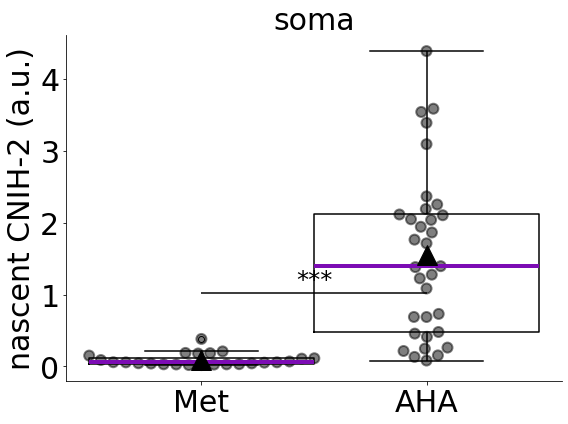

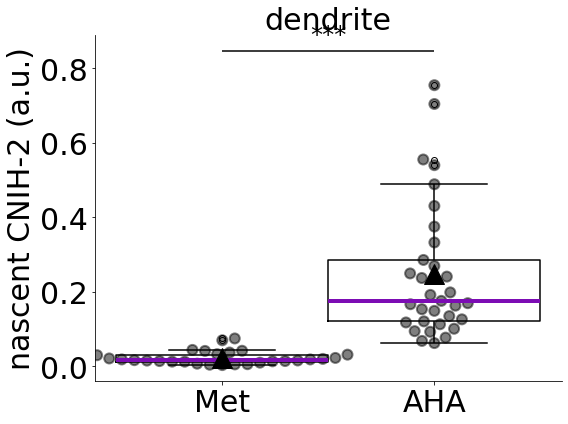

In [12]:
# compart = compartments[0]
unit_string = {compartments[0]:" \n in {} / $\mu m^2$".format(compartments[0]),compartments[1]:"\n in {} / $ \mu m$".format(compartments[1])}
for compart in compartments:
    xlab = ""
    title = "{}".format(compart)
    ylab = r"nascent CNIH-2 (a.u.)".format(unit_string[compart])
    SwarmBoxCombo(newprot_density[newprot_density.compartment==compart],
                  x = "compartment",
                  y = "Density",
                  fbase="Fig_new_cnih2_{}_density".format(compart),
                  xlabel=xlab,
                  ylabel=ylab,
                  title=title,
                  Num = False)


In [36]:
newprot_counts = newprot_counts.reset_index()
newprot_counts = newprot_counts.rename(columns={'PID':'Num'})
newprot_counts.head()

,cell_id,treatment,compartment,Num
0,1,AHA,dendrite,195
1,1,AHA,soma,20
2,1,Met,dendrite,2
3,1,Met,soma,2
4,2,AHA,dendrite,229


(2,)
7.17722703428178e-10 33 24
7.17722703428178e-10
***


/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_20025/613234988.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_20025/613234988.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()


(2,)
2.235715260200803e-11 33 28
2.235715260200803e-11
***


/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_20025/613234988.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_20025/613234988.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()


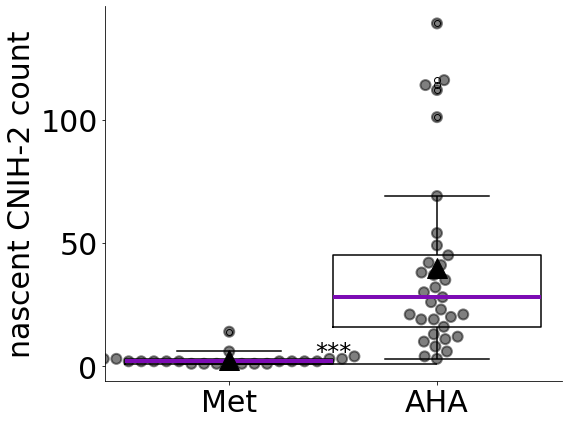

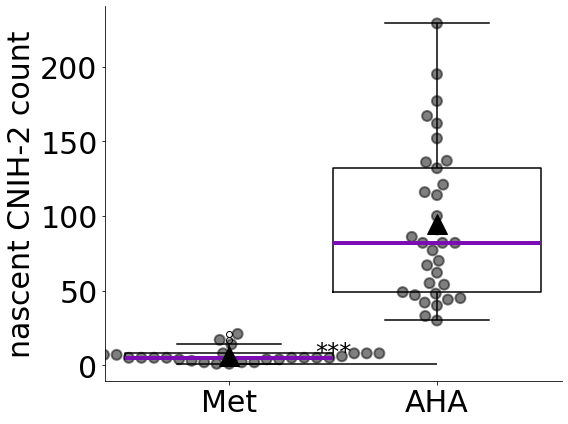

In [37]:
# unit_string = {compartments[0]:"$10 \mu m^2$",compartments[1]:"$10 \mu m$"}
for compart in compartments:
    xlab = ""
    title = ""
    ylab = ylab = r"nascent CNIH-2 count".format(unit_string[compart])
    SwarmBoxCombo(newprot_counts[newprot_counts.compartment==compart],
                  x = "compartment",
                  y = "Num",
                  fbase="Fig_new_cnih2_{}_count".format(compart),
                  xlabel=xlab,
                  ylabel=ylab,
                  title=title,
                  Num = True)

## somatic vs dendritic fraction of nascent protein

In [42]:
totals = newprot_counts.groupby(["cell_id","treatment"]).transform('sum')
totals =totals.reset_index()
newprot_counts["fractions"] = newprot_counts["Num"]/totals["Num"]

In [43]:
newprot_counts.groupby(["treatment","compartment"]).mean()

cell_id        Num  fractions
treatment compartment                                 
AHA       dendrite     24.000000  94.666667   0.718328
          soma         24.000000  39.818182   0.281672
Met       dendrite     16.607143   6.250000   0.736314
          soma         17.833333   2.708333   0.307634

(2,)
5.553457781863252e-05 28 24
5.553457781863252e-05
***


/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_20025/613234988.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_20025/613234988.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()


(2,)
1.0588621296364067e-06 33 33
1.0588621296364067e-06
***


/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_20025/613234988.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_20025/613234988.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()


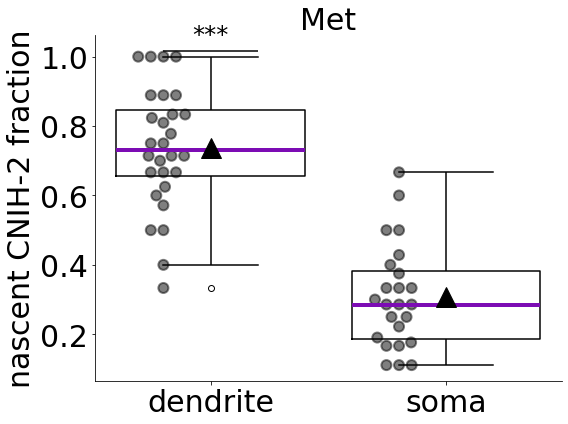

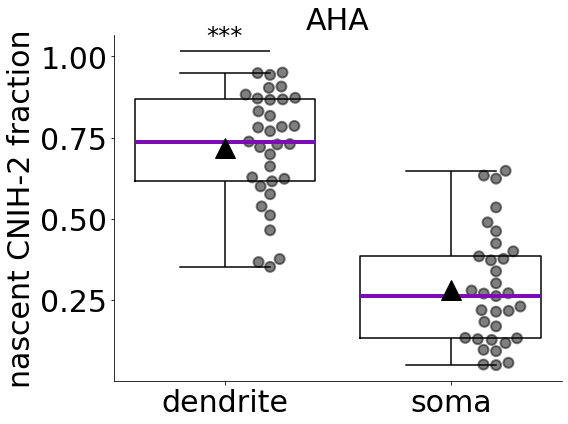

In [44]:
for treat in treatments:
    xlab = ""
    title = treat
    ylab = ylab = r"nascent CNIH-2 fraction".format(unit_string[compart])
    SwarmBoxCombo(newprot_counts[newprot_counts.treatment==treat],
                  x = "compartment",
                  y = "fractions",
                  fbase="Fig_new_cnih2_{}_fraction".format(treat),
                  xlabel=xlab,
                  ylabel=ylab,
                  title=title,
                  label_poss = None,
                  Num = True)